In [19]:
import stim
from tsim.circuit import Circuit
import matplotlib.pyplot as plt
import numpy as np
import tsim.external.pyzx as zx
import time

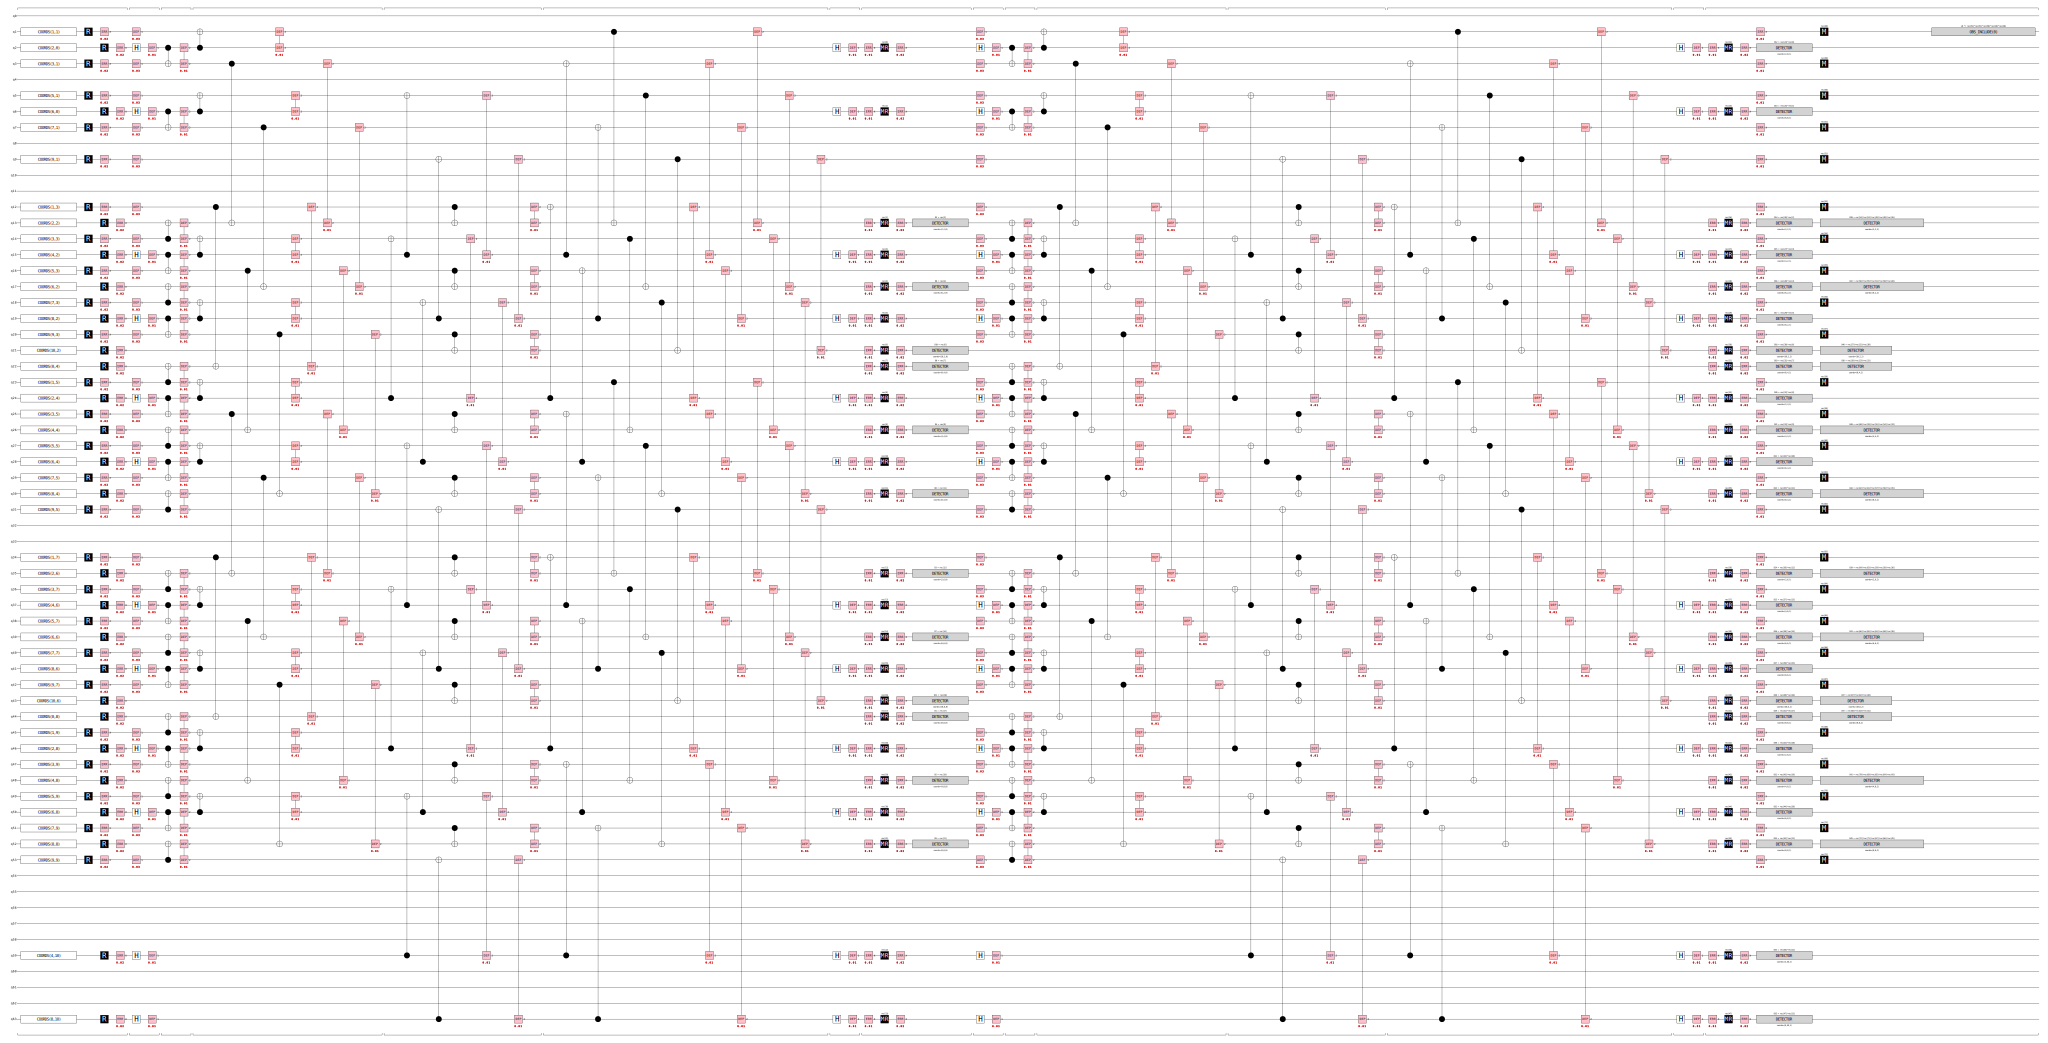

In [41]:
p = 0.01
stim_circ = stim.Circuit.generated(
    # "repetition_code:memory",
    "surface_code:rotated_memory_z",
    distance=5,
    rounds=2,
    after_clifford_depolarization=p,
    after_reset_flip_probability=p * 2,
    before_measure_flip_probability=p,
    before_round_data_depolarization=p * 3,
)
stim_circ.diagram("timeline-svg")

In [42]:
c = Circuit.from_stim_program(stim_circ)
c.diagram()
c.without_noise().diagram()

In [43]:
g, _ = c.get_liouville_graph(meas_sampling_mode=True)
zx.draw(g)

In [44]:
sampler = c.compile_sampler()
print(sampler)

CompiledSampler(73 qubits, 73 graphs, 758 parameters, 179 AB terms, 298 C terms, 15 D terms)


In [45]:
n_samples = 200
sampler.sample(n_samples, 100)

array([[1, 1, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]], shape=(200, 73), dtype=int32)

In [25]:
det_sampler = c.compile_detector_sampler()
det_sampler

CompiledSampler(17 qubits, 17 graphs, 34 parameters, 17 AB terms, 0 C terms, 0 D terms)

In [26]:
det_sampler.sample(n_samples)

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 1]], shape=(200, 17), dtype=int32)

In [27]:
stim_sampler = stim_circ.compile_sampler()
stim_det_sampler = stim_circ.compile_detector_sampler()

In [28]:
n_samples = 50_000
samples = sampler.sample(n_samples, 100)
stim_samples = stim_sampler.sample(n_samples)

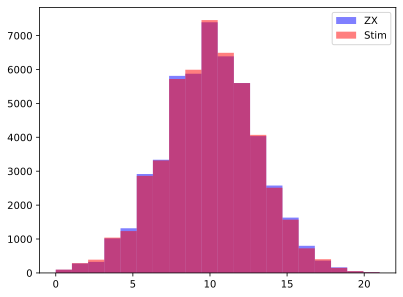

In [40]:
def compare_hist(s1, s2, bins=50):
    h1 = np.count_nonzero(s1, axis=1)
    h2 = np.count_nonzero(s2, axis=1)
    m = np.max([np.max(h1), np.max(h2)])
    plt.hist(h1, alpha=0.5, label="ZX", range=(0, m), bins=bins, color="blue")
    plt.hist(h2, alpha=0.5, label="Stim", range=(0, m), bins=bins, color="red")
    plt.legend()

compare_hist(samples, stim_samples, bins=20)

In [ ]:
n_samples = 5_000

start = time.perf_counter()
obs_samples = det_sampler.sample(n_samples)
duration_zx = time.perf_counter() - start

start = time.perf_counter()
obs_stim_samples = stim_det_sampler.sample(n_samples, append_observables=True)
duration_stim = time.perf_counter() - start


print("\nTime per sample:")
print(f"(ZX)   {duration_zx / n_samples:.2e} seconds")
print(f"(Stim) {duration_stim / n_samples:.2e} seconds")

In [ ]:
compare_hist(obs_samples, obs_stim_samples, bins=20)

Magic state distillation

In [46]:
stim_circ = stim.Circuit.from_file("msd_circuits/d=5_X.stim")
c = Circuit()
num_qubits = stim_circ.num_qubits
block_size = num_qubits // 5
targets = np.arange(5) * block_size + (6 if block_size == 7 else 7)

c.r(range(num_qubits))

c.h(targets)
c.t(targets)
c.h(targets)

c.append_from_stim_program(stim_circ)
c.diagram(labels=False)

In [ ]:
# g, _ = c.get_liouville_graph(meas_sampling_mode=False)
# zx.draw(g)

In [47]:
sampler = c.compile_detector_sampler()
print(sampler)

CompiledSampler(45 qubits, 94 graphs, 145 parameters, 289 AB terms, 355 C terms, 33 D terms)


In [49]:
sampler.sample(100, 50) # 10ms, 25ms 

array([[0, 0, 1, ..., 0, 1, 0],
       [0, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 0, 0]], shape=(100, 45), dtype=int32)